## Agricultural Water usage ##


In this experiment we strive to understand and visualize the global agricultural water withdrawal. It is responsible for the largest share of the total water withdrawal and mostly used for irrigated crop harvesting.

Agricultural water withdrawal is essential to provide a stable and sufficient food supply for the population of a country.

We want to analyze how different countries cope with agriultural water withdrawal, expecially if they already suffer under high water stress.

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys
import os
import math
from tueplots.constants.color import rgb
from tueplots import bundles
import seaborn as sns
import pandas as pd

plt.rcParams.update(bundles.icml2022())
plt.rcParams.update({"figure.dpi": 200})

sys.path.insert(1, os.path.abspath(os.getcwd()[:-3]))

First we compute and visualize the total (global) share of the three different main sectors:
- Industral Withdrawal
- Agricultural Withdrawal
- Municipial Withdrawal

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


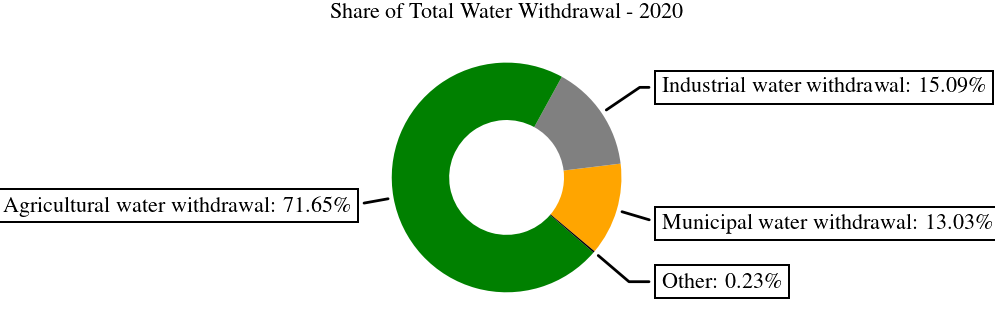

In [60]:
from src.aquastat_utils import get_aquastat
from src.aquastat_utils import plot_world
import geopandas as gpd
from src.utils import to_dat_path
from src.aquastat_utils import rename_aquastat_country

df = get_aquastat()
year = 2020

variables = ['Total water withdrawal', 'Municipal water withdrawal', 'Industrial water withdrawal',
                 'Agricultural water withdrawal']
'''filter countries (no filter if empty)'''


data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
df = data[data['Year'] == year]

# Aggregate data
df = df[['Country', *variables]]

total_water = sum(df['Total water withdrawal'])
municipial_water = sum(df['Municipal water withdrawal'])
industrial_water = sum(df['Industrial water withdrawal'])
agricultural_water = sum(df['Agricultural water withdrawal'])
other = total_water - municipial_water - industrial_water - agricultural_water


fig, ax = plt.subplots(figsize=(5, 3), subplot_kw=dict(aspect="equal"))


data = [municipial_water/total_water, industrial_water/total_water, agricultural_water/total_water, other/total_water]

categories = ["Municipal water withdrawal: " + str(round(100 * municipial_water/total_water, 2)) + "\%",
          "Industrial water withdrawal: " + str(round(100 * industrial_water/total_water, 2)) + "\%",
          "Agricultural water withdrawal: " + str(round(100 * agricultural_water/total_water, 2)) + "\%",
          "Other: " + str(round(100 * other/total_water, 2)) + "\%"]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40, 
                       colors=['orange', 'grey', 'green', 'black'])

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(categories[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)
ax.set_title("Share of Total Water Withdrawal - 2020")

plt.show()


As previously stated, we can observe the agricultural water withdrawal is responsible for the vast majority of the total water withdrawal.

As a next step we visualize the total water withdrawal for each country.

In [61]:
# discrete colormap

def create_discrete_colormap():
    # Define the colors for the colormap
    colors = [(1, 1, 0, 0.3), (0.8, 1, 0.1, 0.5), (0.6, 0.8, 0.2, 0.7), (0.3, 0.6, 0.4, 0.7), (0.2, 0.4, 0.6, 1), (0, 0.4, 0.8, 1), (0, 0.0, 0.8, 1), (0, 0, 0.5, 1)]  # Yellow, Light Blue, Dark Blue
    boundaries = [0, 0.005, 0.01, 0.1, 1, 5, 10, 50, 100]  # Custom boundaries for each color segment

    # Create a colormap using LinearSegmentedColormap
    cmap_name = 'custom_colormap'
    cmap = ListedColormap(colors)

    # Create a norm instance to map data values to the colormap
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    return cmap, norm

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


Text(0.5, 0.05, 'Source: AQUASTAT')

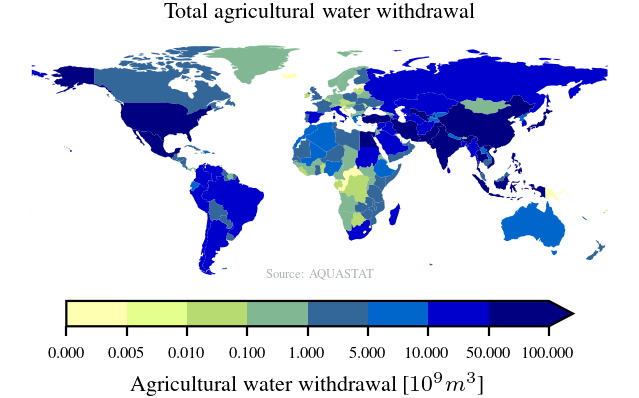

In [62]:
df = get_aquastat()

custom_cmap, norm = create_discrete_colormap()

'''Plot a map vizualizing the Agricultural Water Withdrawal'''
year = 2020
variables = ["Agricultural water withdrawal"]
title = 'Total agricultural water withdrawal'

world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")

# Rename the countries to match the names in the world dataframe
# Extract relevant variables and drop all NaN
data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
countries_df = data[data['Year'] == year]

# Aggregate data
countries_df = countries_df[['Country', *variables]]

# Rename countries to match the world map
for country in countries_df['Country'].unique():
    replace_to = rename_aquastat_country(country)
    countries_df.replace(to_replace={country: replace_to}, inplace=True)

# Merge data with world map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
world = world.merge(countries_df, left_on='SOVEREIGNT', right_on='Country')

# Create figure

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot using geopandas
plot = world.plot(column=variables[0], ax = ax, legend=True, cmap=custom_cmap, norm = norm,
            legend_kwds={'label': "Agricultural water withdrawal [$10^9 m^3$]", 'orientation': "horizontal",
                        'shrink': 0.8, 'extend': 'max', 'format': '%.3f'})

ax.set_title(title)
ax.axis("off")

# Add source
plt.text(0.5, 0.05, 'Source: AQUASTAT', fontsize = 'xx-small', horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color=rgb.tue_gray)

As expected, countries with a high population count also have high absolute water withdrawal for the agricultural sector.

Since there are many countries where most crops can grow through rainfall without artificial irrigation, these are not accounted for in the agricultural water withdrawal statistic. To also gain a comprehensive understanding of the overall extent of agricultural activities within a country, we investigate the share of the total area of a country that is cultivated."

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


Text(0.5, 0.05, 'Source: AQUASTAT')

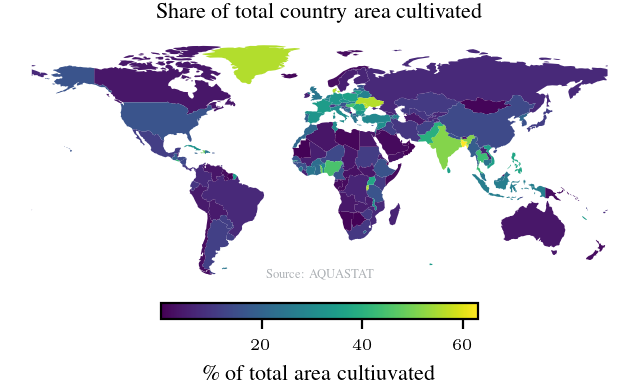

In [63]:
df = get_aquastat()

custom_cmap, norm = create_discrete_colormap()

'''Plot a map vizualizing the Share of total area of a country that is cultivated'''
year = 2020
variables = ["% of total country area cultivated"]
title = 'Share of total country area cultivated'

world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")

# Rename the countries to match the names in the world dataframe
# Extract relevant variables and drop all NaN
data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
countries_df = data[data['Year'] == year]

# Aggregate data
countries_df = countries_df[['Country', *variables]]

# Rename countries to match the world map
for country in countries_df['Country'].unique():
    replace_to = rename_aquastat_country(country)
    countries_df.replace(to_replace={country: replace_to}, inplace=True)

# Merge data with world map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
world = world.merge(countries_df, left_on='SOVEREIGNT', right_on='Country')

# Create figure

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot using geopandas
plot = world.plot(column=variables[0], ax = ax, legend=True, cmap='viridis',
            legend_kwds={'label': "\% of total area cultiuvated", 'orientation': "horizontal",
                        'shrink': 0.5})

ax.set_title(title)
ax.axis("off")
# Add source
plt.text(0.5, 0.05, 'Source: AQUASTAT', fontsize = 'xx-small', horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color=rgb.tue_gray)

Finally we visualize the share of the total water withdrawal that is allocated for the agricultural sector.

This is an interesting variable, since it reveals how much of the available water is used for agricultural purposes. In particular this variable might reveal different strategies for countries that have different water stress levels.

In [64]:
# discrete colormap

def create_discrete_colormap():
    # Define the colors for the colormap
    colors = [(0,0,0,0.1), (95/255, 128/255, 194/255, 0.5), (59/255, 113/255, 222/255, 0.78), (13/255, 130/255, 178/255, 0.78), (0, 38/255, 139/255, 0.78)]  # Yellow, Light Blue, Dark Blue
    boundaries = [0, 20, 40, 60, 80, 100]  # Custom boundaries for each color segment

    # Create a colormap using LinearSegmentedColormap
    cmap_name = 'custom_colormap'
    cmap = ListedColormap(colors)

    # Create a norm instance to map data values to the colormap
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    return cmap, norm

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


Text(0.5, 0.05, 'Source: AQUASTAT')

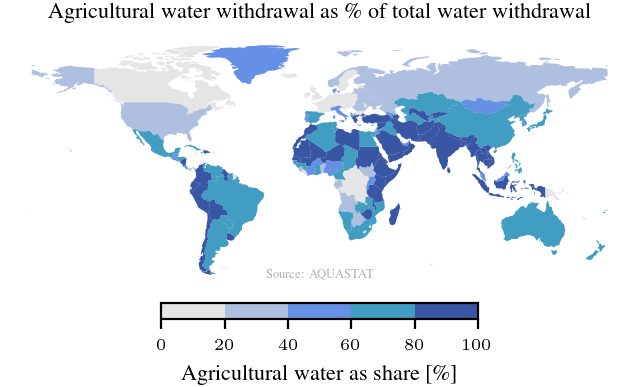

In [65]:
df = get_aquastat()

custom_cmap, norm = create_discrete_colormap()

'''Plot a map vizualizing the Agricultural Water Withdrawal as share of total water withdrawal'''
year = 2020
variables = ["Agricultural water withdrawal as % of total water withdrawal"]
title = 'Agricultural water withdrawal as \% of total water withdrawal'

world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")

# Rename the countries to match the names in the world dataframe
# Extract relevant variables and drop all NaN
data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
countries_df = data[data['Year'] == year]

# Aggregate data
countries_df = countries_df[['Country', *variables]]

# Rename countries to match the world map
for country in countries_df['Country'].unique():
    replace_to = rename_aquastat_country(country)
    countries_df.replace(to_replace={country: replace_to}, inplace=True)

# Merge data with world map
world = gpd.read_file(to_dat_path(file_path='naturalearth/ne_110m_admin_0_countries.shx'), engine="pyogrio")
world = world.merge(countries_df, left_on='SOVEREIGNT', right_on='Country')

# Create figure

plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot using geopandas
plot = world.plot(column=variables[0], ax = ax, legend=True, cmap=custom_cmap, norm = norm,
            legend_kwds={'label': "Agricultural water as share [\%]", 'orientation': "horizontal",
                        'shrink': 0.5})

ax.set_title(title)
ax.axis("off")
# Add source
plt.text(0.5, 0.05, 'Source: AQUASTAT', fontsize = 'xx-small', horizontalalignment='center', verticalalignment='center',transform=plt.gca().transAxes, color=rgb.tue_gray)

Next, we want to analyze the impact of the water stress levels on the share of water that is allocated for the agricultural sector.

Given the critical role of the agricultural sector in ensuring the food supply for the population we might be able to observe that countries with high water stress prioritize this sector. This would increase the relative water withdrawal share for agricultural uses.

To investigate this the data is split into three groups based on the water stress:

- Group 1: Countries with water stress $x \leq 20\%$
- Group 2: Countries with water stress $20\% < x \leq 40\%$
- Group 3: Countries with water stress $40 < x\%$

To get a visual impression of the distribution of the three groups boxplots are created.

Getting AQUASTAT dataframe from fao_aquastat.csv ...
/home/marten/Uni/Semester_2/Data_Literacy/Datascience_Project/team-acqua/src/../dat/fao_aquastat.csv already exists.
Renaming countries ...


Text(0.5, 0, 'Water Stress Categories')

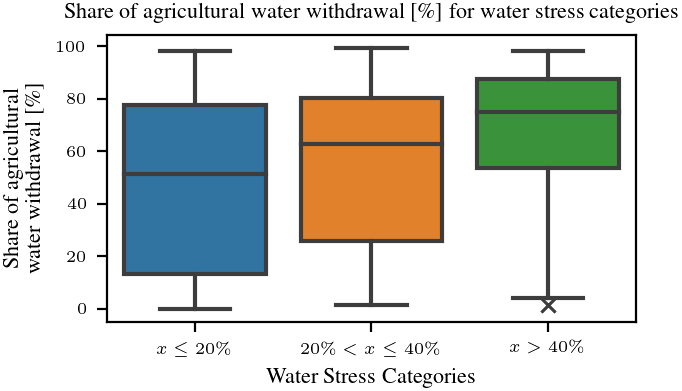

In [66]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

df = get_aquastat()
year = 2020

variables = ['SDG 6.4.2. Water Stress', 'Agricultural water withdrawal as % of total water withdrawal']

data = df[['Country', 'Year', *variables]]
data = data.dropna()

# Filter for specific year
df = data[data['Year'] == year]

# Aggregate data
df = df[['Country', *variables]]

# split into two groups based on water stress
# countries with a water stress level above 40% are considered to have high stress
g1 = df[df['SDG 6.4.2. Water Stress'] <= 20]
g2 = df[(df['SDG 6.4.2. Water Stress']<=40) & (df['SDG 6.4.2. Water Stress']>20)]
g3 = df[df['SDG 6.4.2. Water Stress'] > 40]

df = pd.Series(g1['Agricultural water withdrawal as % of total water withdrawal'].to_numpy(), name="$ x \leq 20\%$").to_frame().join(
    pd.Series(g2['Agricultural water withdrawal as % of total water withdrawal'].to_numpy(), name="$20\% < x \leq 40\%$"))
df = df.join(pd.Series(g3['Agricultural water withdrawal as % of total water withdrawal'].to_numpy(), name="$x > 40\%$"))


plt.rcParams.update(bundles.icml2022())
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

sns.boxplot(data=df, ax = ax, flierprops={"marker": "x"}) 
ax.set_title("Share of agricultural water withdrawal [\%] for water stress categories")
ax.set_ylabel("Share of agricultural\n water withdrawal [\%]")
ax.set_xlabel("Water Stress Categories")

The first visual analysis already seems to reveal that there is a significat difference between the three classes in their strategies regarding the distribution of then withdrawn water.

We want to validate this observation by employing a statistical method like ANOVA.
To choose the correct test, we need to check whether the data is normally distributed. Therefore we construct PP and QQ-Plots assuming that the given data is normally distributed.

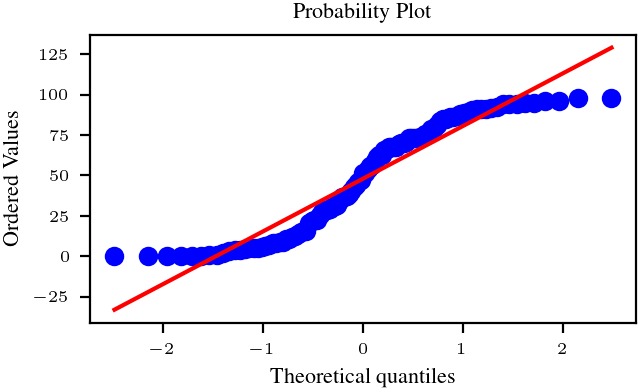

In [70]:
import scipy.stats as stats
import matplotlib
# to test for normalcy we construct a qq and pp plot of the data

# qq plot
data = g1['Agricultural water withdrawal as % of total water withdrawal'].to_numpy()
stats.probplot(data, dist="norm", plot=matplotlib.pyplot)
plt.show()

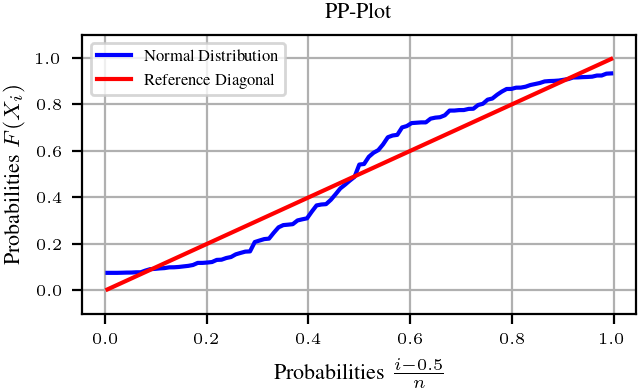

In [68]:
# pp plot

from scipy.stats import norm
s1 = np.sort(data)
mu = s1.mean()
std = s1.std()


def pp_plot(X, params = [], plt_title = "PP-Plot"):
    n = len(X)
    i = np.arange(1, n+1, step=1)

    x = (i-0.5) / n
    
    # set params for normal distribution
    rv = stats.norm(loc=params[0],scale=params[1])
    y1 = rv.cdf(X)

    fig, ax = plt.subplots()
    ax.plot(x, y1, color = "blue", label = "Normal Distribution")
    ax.plot(x, x, color = "red", label = "Reference Diagonal")
    ax.set_ylabel("Probabilities $F(X_i)$")
    ax.set_xlabel(r"Probabilities $\frac{i-0.5}{n}$")
    ax.set_title(plt_title)
    ax.set_ylim(-0.1, 1.1)
    ax.legend()
    ax.grid()

pp_plot(s1, [mu, std], plt_title='PP-Plot')

plt.show()

It becomes apparent that the distribution of the agricultural water withdrawal is not normally distributed. It this were the case the computed values for the Normal Distribution (blue line) would resemble the reference diagonal closely.

Since we cannot assume that the sample data is distributed normally, we cannot conduct an ANOVA test since normalcy is a requirement.

Instead we perform the Kruskal Wallis test, where normalcy is not required. The taget of the Kruskal Wallis test is to check whether there are significant differences in the medians of two or more groups.

We apply this test to check whether the observed difference regarding a countries share of agricultural water withdrawal is significant. We have seperated the countries into three groups based on their water stress levels and already observed visually that there seems to be a notable difference in the share of agricultural water withdrawal.

The Null Hypothesis is defined as follows: All group mean ranks (medians) are equal.

The Kruskal Wallis test statistic H is approximately chi-squared distributed with k-1 degrees of freedom, where k is the number of groups (here 3)

$$
    H = (\frac{12}{N(N+1)}\sum_{j=1}^k \frac{R_j^2}{n_j}) -3(N+1)
$$

$N$ is the total sample size, $n_j$ is sample size for group $j$ and $R_j$ is the sum of ranks of the $j$-th group.

In [69]:
group1 = g1['Agricultural water withdrawal as % of total water withdrawal'].to_numpy()
group2 = g2['Agricultural water withdrawal as % of total water withdrawal'].to_numpy()
group3 = g3['Agricultural water withdrawal as % of total water withdrawal'].to_numpy()

stats.kruskal(group1, group2, group3)


KruskalResult(statistic=9.251801019413538, pvalue=0.00979483072308621)

We obtain a $p$-value of 0.009. This is smaller than the significance level of $\alpha = 0.05$ thus we can conclude to reject the Null Hypothesis, which means that there is a meaningful difference between the medians of the three groups.

While the test only enables us to reject the Null Hypothesis but does not provide explanations for this, we can speculate that countries that deal with increasing water stress allocate the available water resources for crucial sectors, here especially the agricultural sector. 

Such a strategic reallocation of water resources underscores the decision-making processes nations engage in when faced with environmental challenges, with an apparent focus on safeguarding vital sectors like agriculture amid escalating water scarcity concerns.